The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [3]:
# Import the dataset
df = pd.read_csv('/content/AB_Test_Results.csv')

In [6]:
print(df.shape)
print(df.head())
df.info()
df.nunique()
df.describe()

(10000, 3)
   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Let's see if there are users who have two A/B test groups

In [7]:
# Look at the distribution of the number of unique groups for each user
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count


,count
VARIANT_NAME,
1,4783
2,1541


In [8]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
double_variant_count / double_variant_count.sum()

,count
VARIANT_NAME,
1,0.756325
2,0.243675


We see that there is 24% of such users. If you take these users into account, then the effect of changes in the experiment will be blurred. Therefore, we exclude user data from the calculation of changes in the experiment

In [9]:
# TODO : users with1 A/B test group
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
# Take only these users
single_variant_users = single_variant_users[single_variant_users]

In [10]:
# Leave only records with users with the 1st ab test group
df = df[df['USER_ID'].isin(single_variant_users.index)]
# TODO : Check that the number of users matches what it was before the exception
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

Let's see how the data is distributed

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

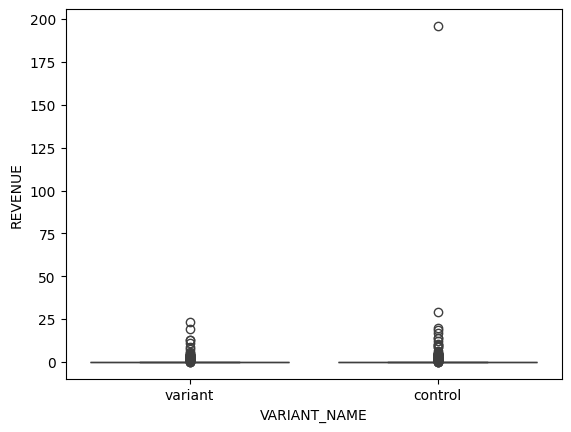

In [12]:
# TODO : Check how the data is distributed using a box plot
# Suppress specific warnings related to future pandas behavior
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [13]:
# Sort these revenue values in descending order
df.sort_values(by='REVENUE', ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


In [14]:
# See if user 3342 had other events with a strong outlier
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

([<matplotlib.axis.XTick at 0x7f29dedf60b0>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

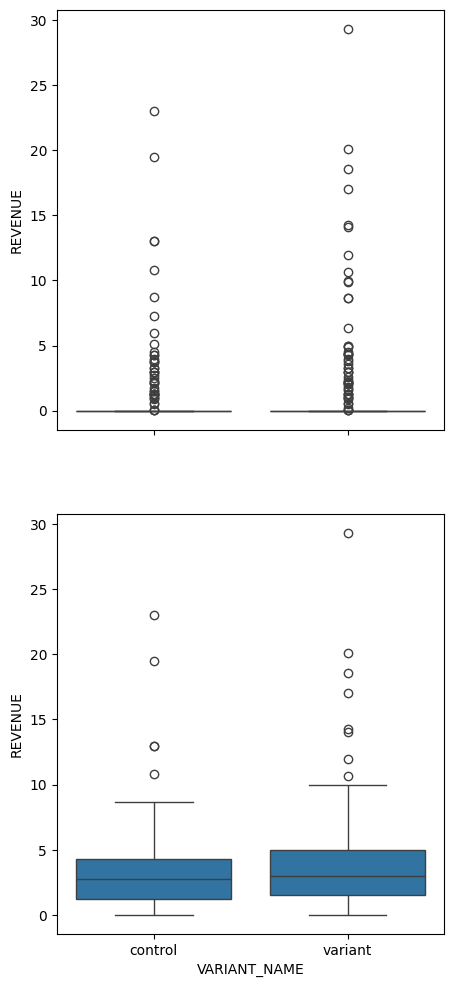

In [15]:
# Rempve the outlier
df = df[df['USER_ID'] != 3342]

f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

We see that most of the users have no purchases. Let's see either this is information on all users, regardless of their actions, or these records are put down in case of entry without purchases and there may be other records with positive revenue.

In [16]:
# TODO : Check if there are users who have records with zero and positive revenue
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)),
    'USER_ID'
]).count()

52

The same user can have records with both zero and positive revenue.

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [17]:
# Group the data for each user and sum the revenue for each to get one record per user
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

([<matplotlib.axis.XTick at 0x7f29ded3eda0>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

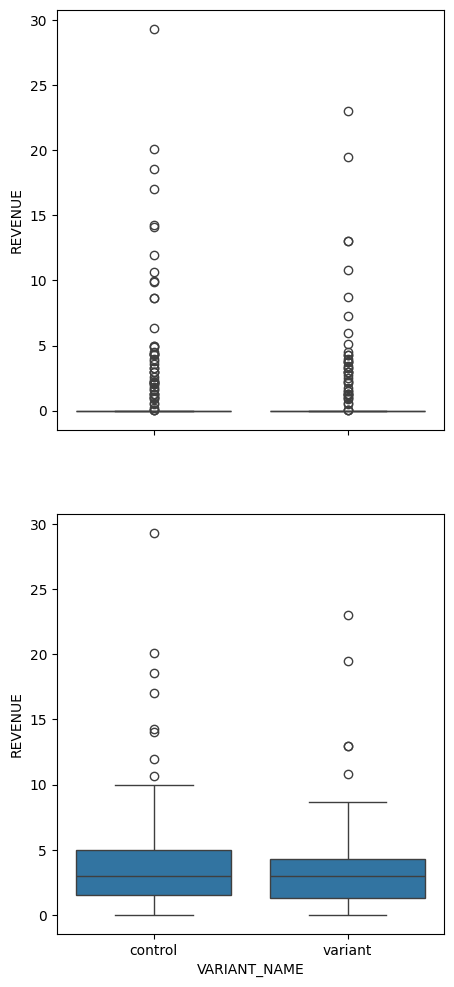

In [18]:
# Visualize the resulting distribution of the data again.
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [19]:
# get metrics by groups
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

# create two additional metrics to see relative changes
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# add them to the rest of the metrics in a separate group
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat


USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

We see that in the test group, the total amount of revenue and the average check per user decreased, but the number of orders per user slightly increased

Let's also see how paying users behave :

In [20]:
# get metrics by groups
paid_stat = df.loc[df.REVENUE != 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                     'REVENUE': ['sum', 'mean', 'median', 'count']})

# add two additional metrics to see relative changes
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

Let's look at the distributions of all and only paying users

<ipython-input-21-6823f3e6b917>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-21-6823f3e6b917>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'],

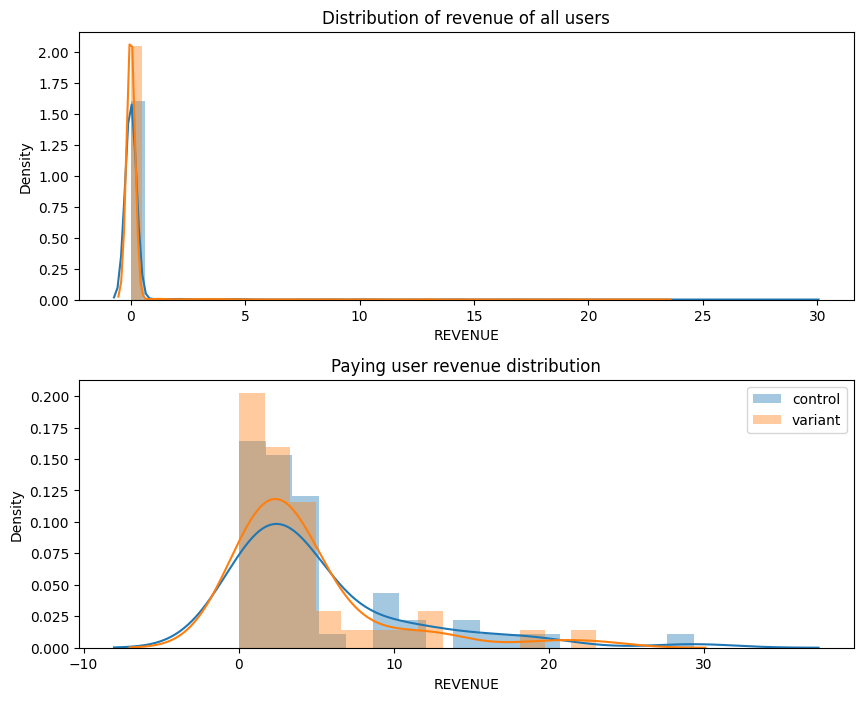

In [21]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [30]:
# Use the Shapiro-Wilk criterion to confirm it
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=0.06145986897942335, pvalue=9.962810723092505e-76)

The null hypothesis about the normal distribution of the data is rejected

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [31]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,4687
False,95


In [32]:
# Check on the data of all users the value of the statistics of the Mann-Whitney test
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

In [33]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'],
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [34]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [35]:
# Generate samples for all users
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [36]:
# TODO : Generate samples for only paying users
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Let's look at the distribution of means in the ab test groups

Text(0.5, 1.0, 'Sample mean distribution for all users')

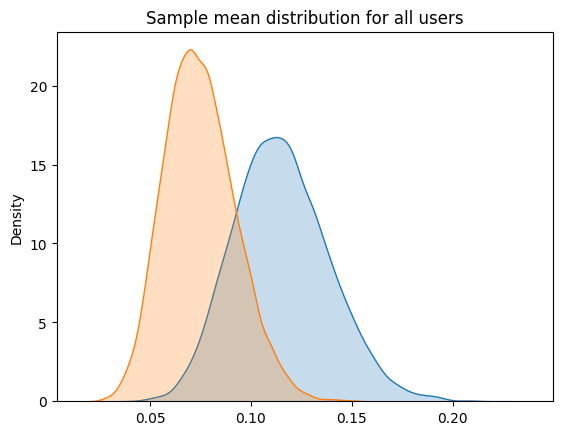

In [37]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

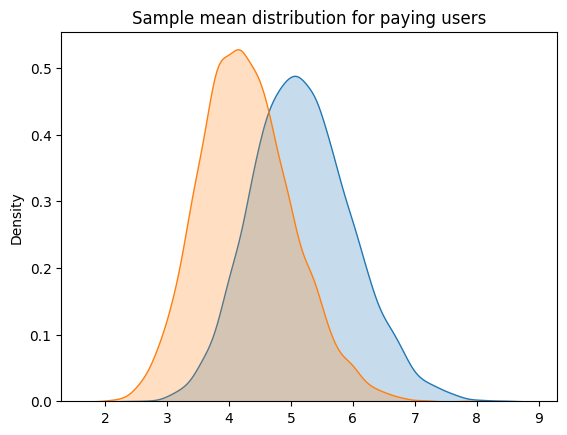

In [38]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

We see that there are differences, but the confidence intervals may overlap, so you need to look at the distribution of the difference in the means between the groups in order to draw final conclusions.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [41]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=False).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

array([-0.09861264,  0.01768785])

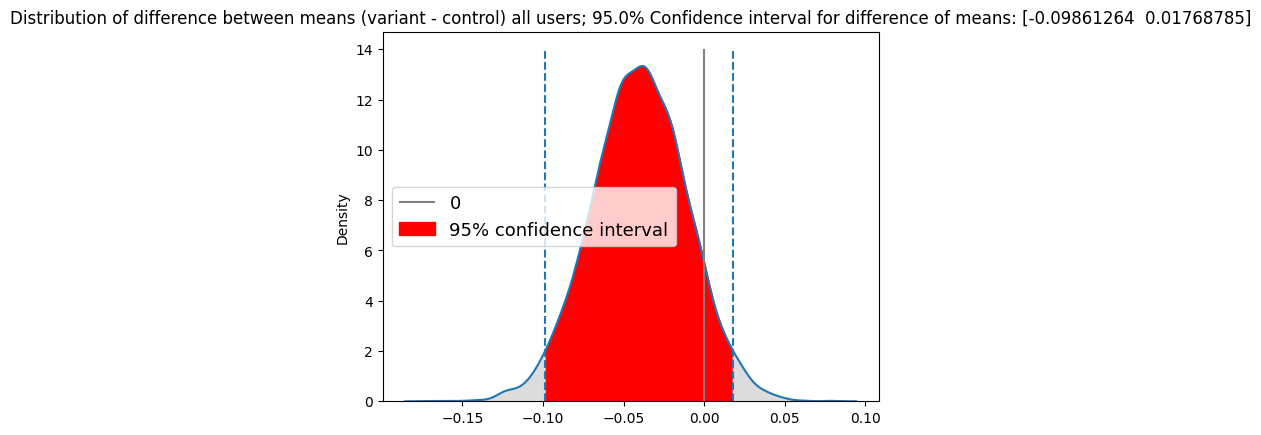

In [42]:
plot_distribution_and_stat_intervals(
    np.mean(variant, axis=1),
    np.mean(control, axis=1),
    title='all users'
)

array([-3.02551359,  1.26375831])

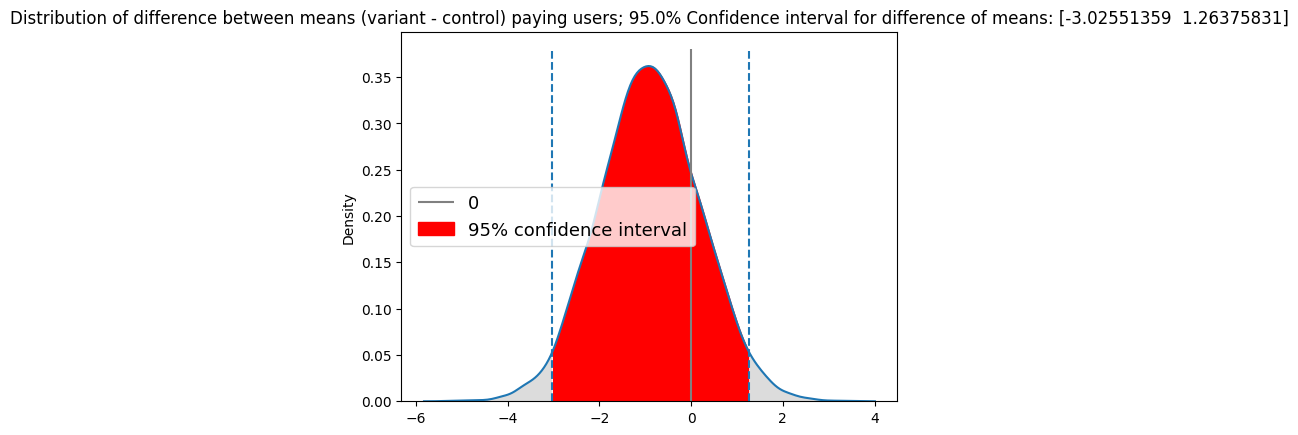

In [43]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

We see that the zero value is within the confidence interval, so we cannot say about the stat. significant change in average revenue between ab test groups.

### Conclusions

In order to draw conclusions about the differences between A/B test groups, the following steps were taken:

- **Exclusion of users assigned to both A/B test groups**: To isolate the impact of the test conditions, users who were present in both groups were removed from the analysis.
- **Outlier removal**: The user with `USER_ID=3342` was excluded, as this individual was a strong outlier in the sample and could skew results, particularly given the limited data.
- **Aggregating user-level data**: Each user was treated as the experimental unit, and their revenue was summed to create a single record per user.

Despite a noticeable reduction in revenue in the variant group, **no statistically significant differences** were found between the A/B test groups, whether examining all users or only paying customers. Further analysis, including data from an A/A test and an investigation into the power of the statistical tests, would be useful for deeper insights.
